In [2]:
import pandas as pd
import numpy as np
import warnings
import json
import matplotlib.pyplot as plt
import seaborn as sns
#from TestLab import ABCore, ABEstimation
#from omegaconf import OmegaConf
from scipy import stats
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

## Дизайн теста

### Рассчет ключевых параметров будущего эксперимента. 
- Посмотрим на распределение целевой метрики, 
- Построим матрицы эффектов и размера выборки,
- Проверим корректность работы критерия,
- Соберем тестовую и контрольную группы.

Основные функции дизайна принимают на вход 2 датафрейма с метрикой и стратами (либо один с метрикой, в зависимости от вашей идеи). Соберем такие таблицы.

In [6]:
sales_ =  # метрика
users =  # страты
sales = sales_[sales_['day'] <= 7] # оставим только первые 7 дней

In [7]:
sales.head()

,user_id,day,sales
0,2661066,0,397
1,3848565,1,841
2,3848565,2,423
3,3848565,4,826
4,3848565,6,859


In [8]:
users.head()

,user_id,gender,age
0,2661066,0,22
1,3848565,1,29
2,5801450,0,24
3,1041736,0,27
4,9545654,1,25


In [9]:
pd.options.display.max_colwidth = 1000
ABCore.DESCRIPTION_ARGS

,Описание параметра,Тип данных
stratification_cols,поля со стратами,List[str] или None
id_field_name,"поле с идентификатором (например, subs_id)",str
groups_count,"количество групп в тесте с учетом (и контрольной, и таргетных)",int
control_share,доля контрольной группы от размера выборки,float
r,отношение самой маленькой группы к самой большой группе (в долях),float
alpha,уровень ошибки I рода,float
beta,уровень ошибки II рода,float
sample_size,размер выборки для всех групп теста,int или None
mde,размер эффекта,float или None
effect_bounds,"границы размеров эффекта в виде массива, например [1.01, 1.02, 1.03, ...]",List[float] или None


In [ ]:
design_dict = {
    'stratification_cols': ['gender', 'age'],
    'id_field_name': 'user_id',
    'groups_count': 3,
    'control_share': 0.5,
    'alpha': 0.05,
    'beta': 0.2,
    'sample_size': None,
    'mde': None, #1.03
    'effect_bounds': None,
    'sample_size_bounds': None,
    'metric_dict': {
        'target_metric_calc': {
            'sales': 'sum'
        },                                              
        'help_metric_calc': {
            'sales': 'sum',
            'sales_1': ['sum', 'mean']
        }
    },
    'n_iter': 50,
    'weights': None,
    'test': 'simple_ttest',
    'stratification': True,
    'stratified_sampling': True
}

#### Первый вариант сборки дизайна - в несколько этапов

Обработаем данные, сделаем расчет метрик и параметров распределения, построим графики.

In [21]:
ab_exp = ABCore(design_dict) # инициализация экземпляра класса

In [22]:
pretty_dict = OmegaConf.to_container(ab_exp.input_params, resolve=True)
ab_exp.print_json(pretty_dict)

{
    "stratification_cols": [
        "gender",
        "age"
    ],
    "id_field_name": "user_id",
    "groups_count": 3,
    "control_share": 0.5,
    "alpha": 0.05,
    "beta": 0.2,
    "sample_size": null,
    "mde": null,
    "effect_bounds": null,
    "sample_size_bounds": null,
    "metric_dict": {
        "target_metric_calc": {
            "sales": "sum"
        },
        "help_metric_calc": {}
    },
    "n_iter": 50,
    "weights": null,
    "test": "simple_ttest",
    "stratification": true,
    "stratified_sampling": true
}


$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

$$\varepsilon^2 > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{n}$$

2023-11-09 17:14:47.584 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1557 - Начало работы
2023-11-09 17:14:47.586 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1558 - Обрабатываю выбросы в данных ...
2023-11-09 17:14:48.306 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1560 - Выбросы обработаны
2023-11-09 17:14:48.308 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1561 - Рассчитываю метрики ...
2023-11-09 17:14:51.216 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1564 - Метрики рассчитаны
2023-11-09 17:14:51.220 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1565 - Рассчитываю параметры распределения ...
2023-11-09 17:14:51.221 | INFO     | t2_ab.t2_ab:_calc_distribution_params:1495 - Расчет параметров распределения со стратификацией для                     пользовательской метрики. Подтягиваю страты ...
2023-11-09 17:14:58.415 | INFO     | t2_ab.t2_ab:_calc_distribution_params:1500 - Страты готовы. Рассчитываю стратифицированные оценки ..

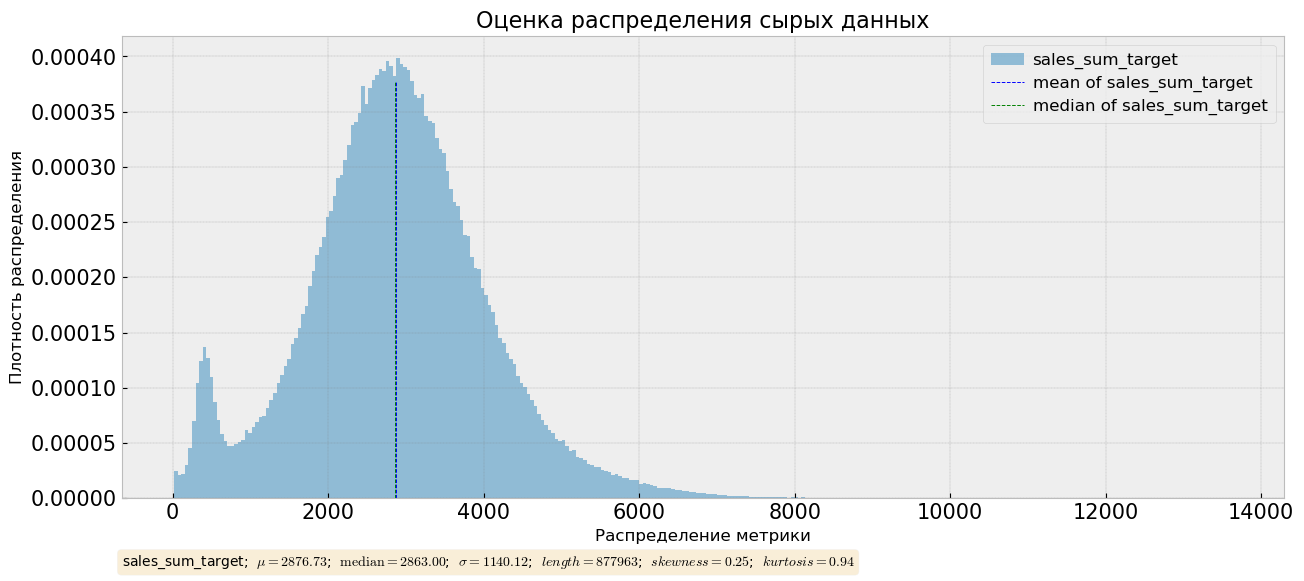

,effects,sample_size,calc_method
0,1.010000,73971,complex
1,1.031111,7643,complex
2,1.052222,2713,complex
3,1.073333,1376,complex
4,1.094444,830,complex
5,1.115556,554,complex
6,1.136667,397,complex
7,1.157778,298,complex
8,1.178889,232,complex
9,1.200000,185,complex


,sample_size,effect_abs,effect_percent
0,1000,247.416284,8.600616
1,3000,142.845858,4.965568
2,5000,110.647926,3.846312
3,7000,93.514566,3.250727
4,9000,82.472095,2.866872
5,11000,74.598817,2.593183
6,13000,68.620931,2.385382
7,15000,63.882610,2.220670
8,17000,60.007263,2.085956
9,19000,56.761188,1.973117


2023-11-09 17:15:05.791 | INFO     | t2_ab.t2_ab:get_sample_sizes_and_effects:1584 - Расчет завершен. Затраченное время (hh:mm:ss.ms) 0:00:18.206977


In [13]:
ab_exp.get_sample_sizes_and_effects(sales, users, ['day'])

После завершения работы метода стали доступны некоторые атрибуты, которые могут быть полезны для проверки качества результатов.

1. Датафрейм с рассчитанными метриками, где целевая метрика имеет постфикс _target, вспомогательные - _help, если метрика была линеаризована - _linear

In [23]:
ab_exp.calc_metrics_df.head()

,user_id,sales_sum_target,sales_sum_help,sales_ratio_help
0,1000002,3781,3781,4.0
1,1000013,3548,3548,8.0
2,1000028,2910,2910,3.0
3,1000043,3181,3181,8.0
4,1000061,3479,3479,10.0


2. Если параметр стратификации определен как True, то к датафрейму с метриками добавятся страты

In [24]:
ab_exp.stratification_df.head()

,user_id,sales_sum_target,sales_sum_help,sales_ratio_help,gender,age,strat_concat_column,period
0,1000002,3781,3781,4.0,1,30,1-30,history
1,1000013,3548,3548,8.0,0,27,0-27,history
2,1000028,2910,2910,3.0,1,20,1-20,history
3,1000043,3181,3181,8.0,0,24,0-24,history
4,1000061,3479,3479,10.0,0,23,0-23,history


3. Словарь с параметрами распределения целевой метрики

In [25]:
ab_exp.params

{'sales': {'mean': 2874.918093644579,
  'var': 1301470.8435404524,
  'std': 1140.8202503201162}}

4. Датафрейм с размерами выборки в зависимости от эффектов

In [26]:
ab_exp.sample_size_matrix.head()

,effects,sample_size,calc_method
0,1.010000,74156,complex
1,1.031111,7662,complex
2,1.052222,2720,complex
3,1.073333,1379,complex
4,1.094444,832,complex


5. Можем построить график

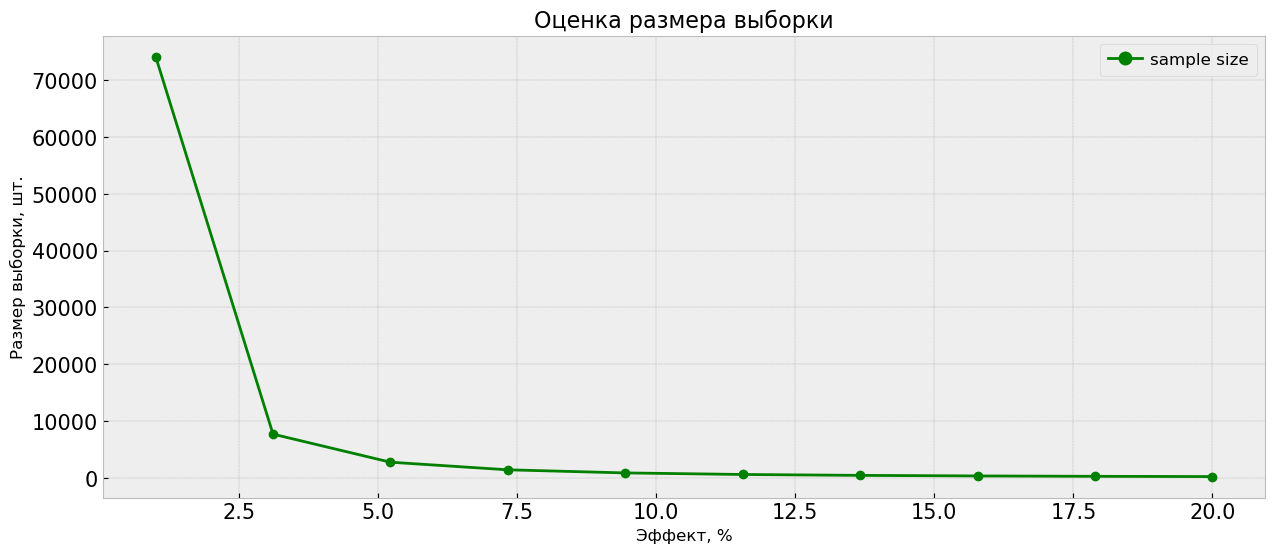

In [27]:
ab_exp.get_sample_size_plot()

6. Датафрейм с эффектами в зависимости от размера выборок

In [28]:
ab_exp.effects_matrix.head()

,sample_size,effect_abs,effect_percent
0,1000,247.569240,8.611349
1,3000,142.934168,4.971765
2,5000,110.716330,3.851113
3,7000,93.572377,3.254784
4,9000,82.523080,2.870450


7. Тоже можем построить график

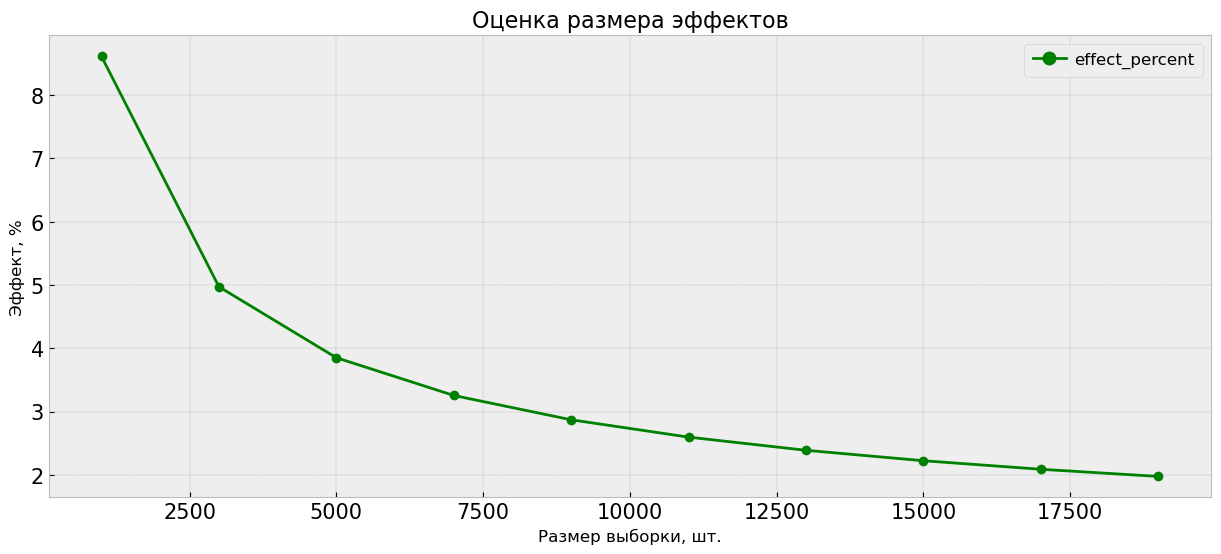

In [29]:
ab_exp.get_effects_plot()

#### A/A/B тест

Для проверки корректности работы статистических тестов на практике принято применять технологию <b>AAB-тестирования</b>. По возможности мы стараемся подобрать две выборки из контрольной группы и одну из пилотной. Если всё идет хорошо, то алгоритм должен заметить разницу между пилотной и контрольной выборками, но при этом не показать различия между двумя контрольными группами.

<b>Вероятность ошибки первого рода</b> --- вероятность отвергнуть нулевую гипотезу при условии, что она верна. То есть вероятность обнаружить значимые различия между двумя контрольными группами. Ведь их не должно быть!

<b>Вероятность ошибки второго рода</b> --- вероятность не отвергнуть нулевую гипотезу при условии, что верна альтернативная гипотеза. То есть вероятность не найти значимых различий между пилотной и контрольной группами. А мы очень хотим их найти!

Необходимо помнить, что ошибки первого типа держаться на уровне 0.05, а ошибки второго уровня уменьшаются при увеличении выборки.

- **Случайное семплирование**. Из всего датасета (объединения данных по отдельным стратам) мы берем без возвращений случайный семпл заданного размера. Для такой выборки считаем среднее.

- **Стратифицированное семплирование**. Из каждой страты мы выбираем число объектов пропорциональное размеру этой страты в генеральной совокупности. Объединяем полученные выборки в итоговую и для неё считаем среднее.

Запустим исторический A/A/B тест. Посмотрим на распределение p-value, ошибки I и II рода и доверительные интервалы

2023-11-09 11:26:17.993 | INFO     | t2_ab:run_AAB_test:1325 - Начало работы
2023-11-09 11:26:17.996 | INFO     | t2_ab:run_AAB_test:1331 - Детектируем эффект в 1.0% или 28.749 единиц в абсолютном выражении
2023-11-09 11:26:17.997 | INFO     | t2_ab:run_AAB_test:1332 - Размер выборки всех групп теста: 74156
2023-11-09 11:26:17.998 | INFO     | t2_ab:run_AAB_test:1333 - Запуск A/A/B теста ...


  0%|          | 0/50 [00:00<?, ?it/s]

,Значения
Оценка вероятности ошибки I рода,0.0200
Доверительный интервал ошибки I рода,"[-0.0188, 0.0588]"
Оценка вероятности ошибки II рода,0.2400
Доверительный интервал ошибки II рода,"[0.1216, 0.3584]"


2023-11-09 11:29:42.413 | INFO     | t2_ab:print_estimated_errors:1086 - Нулевая гипотеза о равенстве средних отвергается на уровне 0.05 при pvalue, равном 0.02.


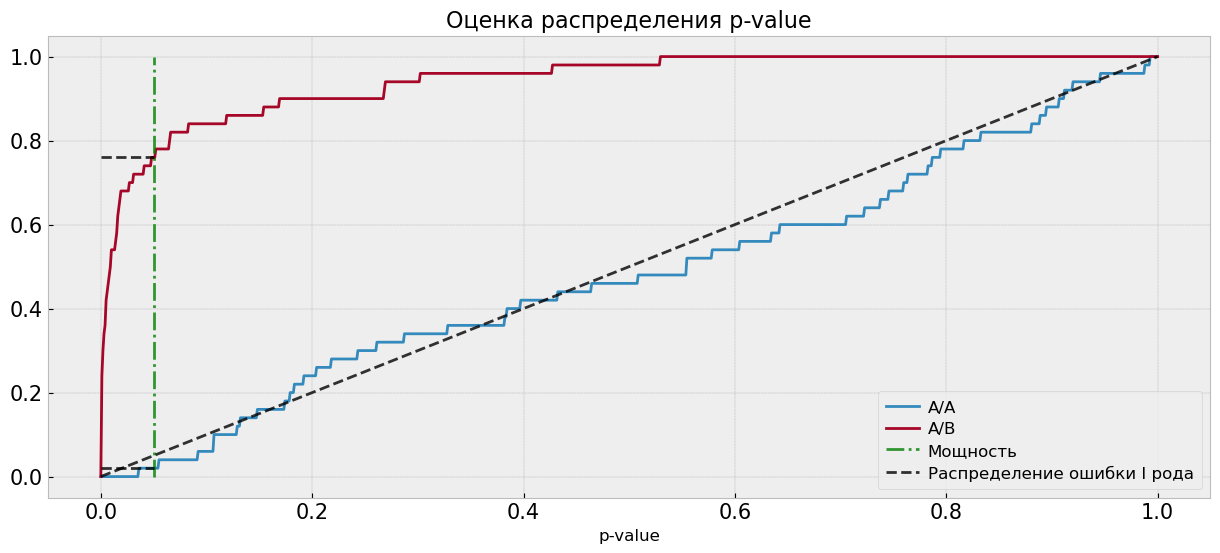

2023-11-09 11:29:42.717 | INFO     | t2_ab:run_AAB_test:1343 - Расчет завершен. Затраченное время (hh:mm:ss.ms) 0:03:24.724451


In [30]:
ab_exp.run_AAB_test()

#### Проблема зависимых случайных величин. Тест Стьюдента по сессиям

- Будем генерировать пользователей со случайным количеством сессий от 3 до 9. 
- У каждого пользователя будет своя средняя длина сессии, множество сессий пользователя будет генерироваться просто добавлением шума к средней длине сессии пользователя.

In [31]:
def get_session_duration(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: List[np.array], список массивов,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    def _user_sessions(mean):
        size = np.random.randint(3,10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    return [_user_sessions(mean) for mean in mean_durations]

In [32]:
get_session_duration(5, effect=0, seed=None)

[array([102., 102.,  86., 101., 106.]),
 array([83., 93., 57.]),
 array([ 79., 101.,  87.,  89.,  77.]),
 array([44., 51., 70., 63., 60.]),
 array([53., 56., 46., 58., 38., 52., 60., 56., 51.])]

In [33]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

Корректно работающий тест дает равномерное распределение p-value для AA-теста.

  0%|          | 0/5000 [00:00<?, ?it/s]

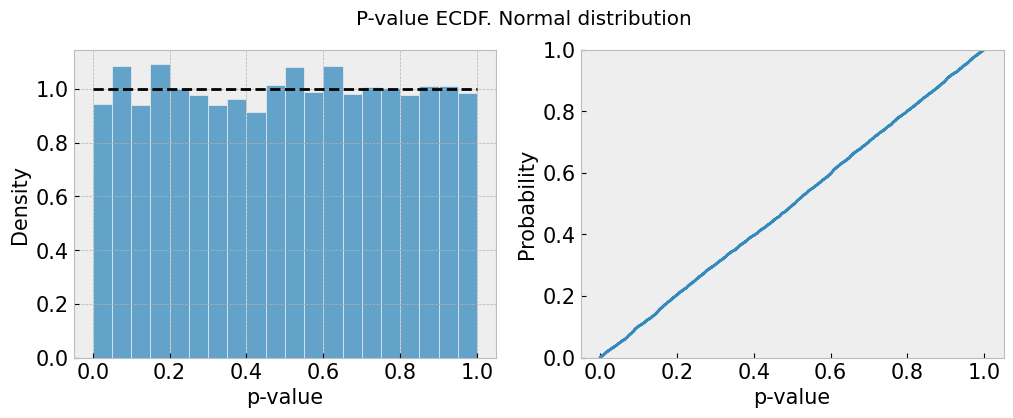

In [34]:
def get_pvalue_samples(a_sample_generator, b_sample_generator, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        _, p = stats.ttest_ind(a_sample_generator(), b_sample_generator())
        pvalues.append(p)
    return pvalues

pvalues = get_pvalue_samples(
    a_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    b_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    size=5000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

В качестве случайных величин возьмем длины сессий пользователей в экспериментальной и контрольной группах.

  0%|          | 0/1000 [00:00<?, ?it/s]

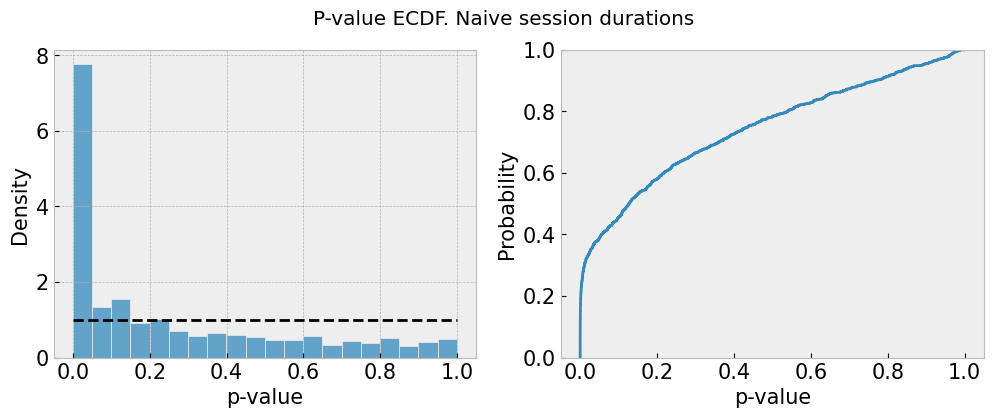

In [35]:
def check_ttest_naive(a, b):
    """Проверка гипотезы с помощью наивного среднего по длинам сессий.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_naive = np.concatenate(a)
    b_naive = np.concatenate(b)
    _, pvalue = stats.ttest_ind(a_naive, b_naive)
    delta = b_naive.mean() - a_naive.mean()
    return pvalue, delta

def naive_session_durations(size=100, effect=0):
    def _durations():
        durations = get_session_duration(size=size, effect=effect)
        return np.concatenate(durations)
    return _durations

pvalues = get_pvalue_samples(
    a_sample_generator=naive_session_durations(size=100, effect=0),
    b_sample_generator=naive_session_durations(size=100, effect=0),
    size=1000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Naive session durations')

Вывод: полученное распределение сильно неравномерное, что говорит о неверно сконструированном тесте.

Получим группы для теста

In [36]:
control_pilot_groups = ab_exp.get_dataframe_with_groups()

2023-11-09 11:34:19.770 | WARNING  | t2_ab:get_dataframe_with_groups:1361 - Количество наблюдений в стратах меньше количества групп. Страты сохранены в объект unit_amount_per_strata_check


In [37]:
control_pilot_groups.groupby('group').count()['user_id']

group
A    37101
B    18552
C    18505
Name: user_id, dtype: int64

In [38]:
ab_exp.groups_weights

[0.5, 0.25, 0.25]

Маленькие выборки несут заметный риск нерепрезентативности.

Иногда можно такую ситуацию предотвратить на этапе дизайна эксперимента. И заранее предусмотреть выбор репрезентативных групп. Но это возможно далеко не всегда. Так если значимых признаков много, то группы получаются сравнительно малого размера и точно подобрать репрезентативные выборки как минимум тяжело. По тем или иным признакам мы можем получить отклонения.

Кроме того, для малых групп существует дополнительная проблема: несбалансированность представленности признака в пилотной и контрольной группах.

При увеличении размера выборки вероятность того, что выборка будет несбалансированная уменьшается.

In [39]:
ab_exp.unit_amount_per_strata_check

{'0-17': 1,
 '0-52': 3,
 '0-53': 3,
 '0-54': 2,
 '0-55': 2,
 '0-56': 1,
 '0-57': 1,
 '0-58': 1,
 '0-59': 1,
 '0-60': 2,
 '1-17': 1,
 '1-50': 3,
 '1-52': 2,
 '1-53': 2,
 '1-54': 2,
 '1-55': 2,
 '1-56': 1,
 '1-57': 1,
 '1-58': 1,
 '1-59': 1,
 '1-60': 2}

Можем проверить, как распределились веса в наших группах

In [ ]:
ab_exp.stratified_dict_check['calc_weights']

In [ ]:
ab_exp.stratified_dict_check['control_group_weights']

In [ ]:
ab_exp.stratified_dict_check['pilot_group_weights']

In [44]:
control_pilot_groups.head()

,user_id,sales_sum_target,sales_sum_help,sales_ratio_help,gender,age,strat_concat_column,period,group
0,4492469,2611,2611,11.0,0,17,0-17,history,A
1,5742523,3283,3283,8.0,0,18,0-18,history,A
2,4860741,2013,2013,2.0,0,18,0-18,history,A
3,1710510,1339,1339,3.0,0,18,0-18,history,A
4,3804616,2995,2995,10.0,0,18,0-18,history,A


#### Второй вариант сборки - одной функцией

In [45]:
ab_exp_2 = ABCore(design_dict)

2023-11-09 11:38:57.944 | INFO     | t2_ab:design_test:1381 - Начало работы
2023-11-09 11:38:57.946 | INFO     | t2_ab:design_test:1382 - Обрабатываю выбросы в данных ...
2023-11-09 11:38:58.762 | INFO     | t2_ab:design_test:1384 - Выбросы удалены
2023-11-09 11:38:58.764 | INFO     | t2_ab:design_test:1385 - Рассчитываю метрики ...
2023-11-09 11:39:01.824 | INFO     | t2_ab:design_test:1388 - Метрики рассчитаны
2023-11-09 11:39:01.826 | INFO     | t2_ab:design_test:1389 - Рассчитываю параметры распределения ...
2023-11-09 11:39:01.827 | INFO     | t2_ab:_calc_distribution_params:1240 - Расчет параметров распределения со стратификацией для пользовательской метрики. Подтягиваю страты ...
2023-11-09 11:39:09.302 | INFO     | t2_ab:_calc_distribution_params:1243 - Страты готовы. Рассчитываю стратифицированные оценки ...
2023-11-09 11:39:09.307 | INFO     | t2_ab:stratify_full_data:695 - Рассчитываю веса страт пропорционально их долям в датафрейме
2023-11-09 11:39:16.320 | INFO     | t2_ab

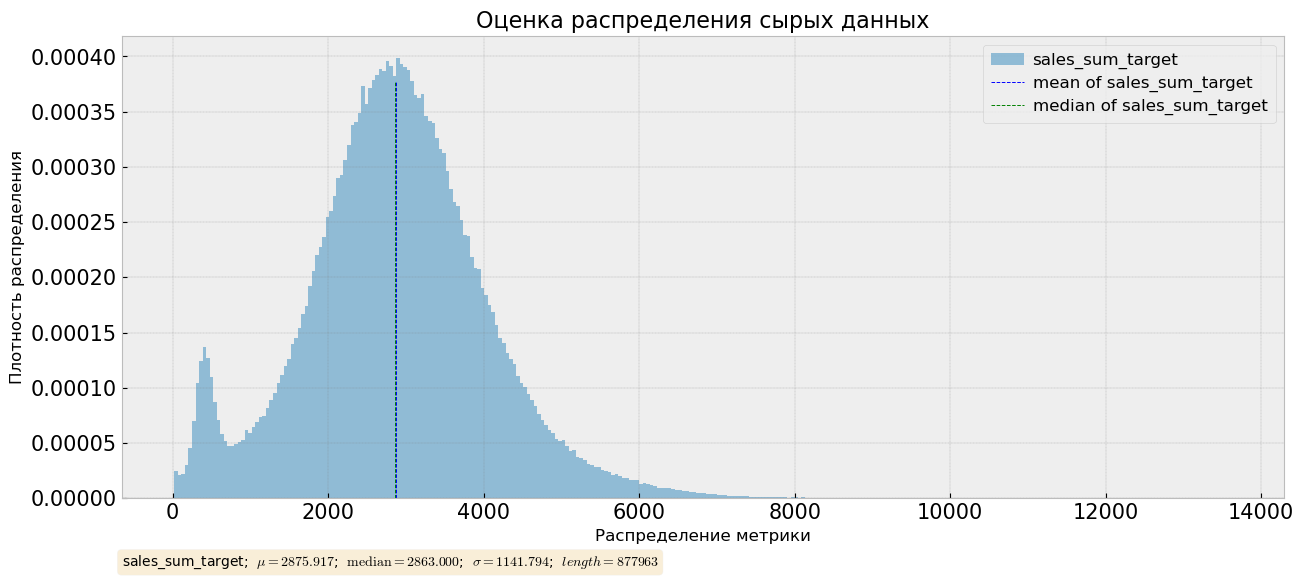

,effects,sample_size,calc_method
0,1.010000,74231,complex
1,1.031111,7670,complex
2,1.052222,2722,complex
3,1.073333,1381,complex
4,1.094444,833,complex
5,1.115556,556,complex
6,1.136667,398,complex
7,1.157778,299,complex
8,1.178889,232,complex
9,1.200000,186,complex


,sample_size,effect_abs,effect_percent
0,1000,247.780446,8.615703
1,3000,143.056107,4.974279
2,5000,110.810784,3.853060
3,7000,93.652206,3.256430
4,9000,82.593482,2.871901
5,11000,74.708615,2.597732
6,13000,68.721931,2.389566
7,15000,63.976636,2.224565
8,17000,60.095585,2.089615
9,19000,56.844733,1.976578


2023-11-09 11:39:17.257 | INFO     | t2_ab:design_test:1405 - Детектируем эффект в 1.0% или 28.759 единиц в абсолютном выражении
2023-11-09 11:39:17.259 | INFO     | t2_ab:design_test:1406 - Размер выборки всех групп теста: 74231
2023-11-09 11:39:17.260 | INFO     | t2_ab:design_test:1407 - Запуск A/A/B теста ...


  0%|          | 0/50 [00:00<?, ?it/s]

2023-11-09 11:42:48.341 | INFO     | t2_ab:design_test:1411 - Подбор контрольной и тестовой групп ...
2023-11-09 11:42:52.734 | WARNING  | t2_ab:design_test:1418 - Количество наблюдений в стратах меньше количества групп. Страты сохранены в объект unit_amount_per_strata_check


,Значения
Оценка вероятности ошибки I рода,0.0200
Доверительный интервал ошибки I рода,"[-0.0188, 0.0588]"
Оценка вероятности ошибки II рода,0.3000
Доверительный интервал ошибки II рода,"[0.1730, 0.4270]"


2023-11-09 11:42:52.744 | INFO     | t2_ab:print_estimated_errors:1086 - Нулевая гипотеза о равенстве средних отвергается на уровне 0.05 при pvalue, равном 0.02.


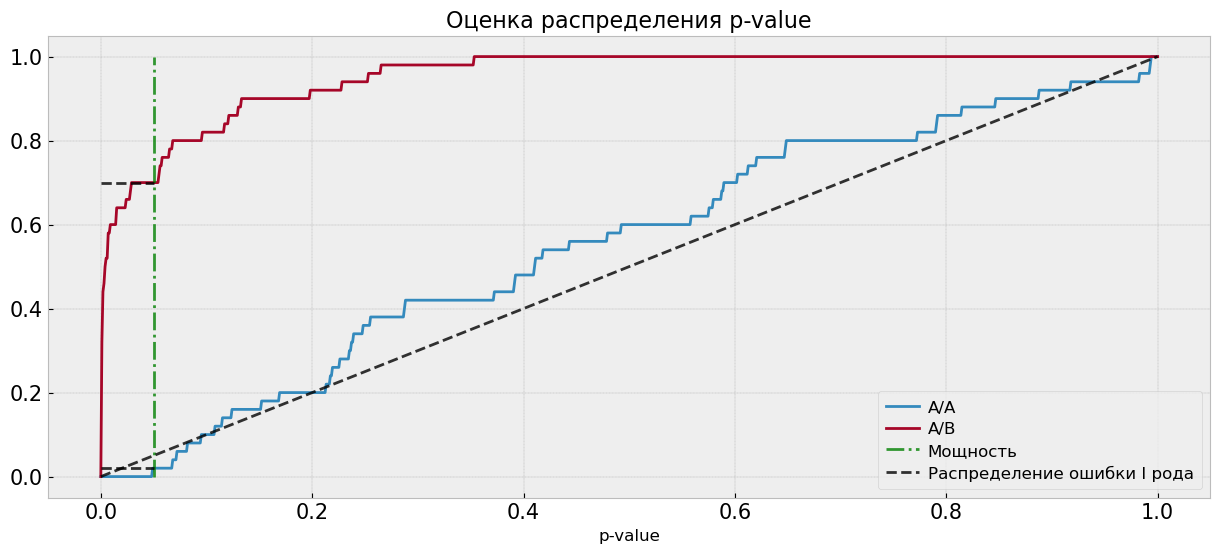

2023-11-09 11:42:53.071 | INFO     | t2_ab:design_test:1427 - Дизайн теста завершен
2023-11-09 11:42:53.073 | INFO     | t2_ab:design_test:1428 - Затраченное время (hh:mm:ss.ms) 0:03:55.126688


In [46]:
control_pilot_groups = ab_exp_2.design_test(sales, users, ['day'])

При этом, нам стали доступны все те же самые атрибуты и методы, что и в первом варианте сборки.

Дизайн теста будем считать завершенным - на основе полученных данных можно скорректировать параметры теста, при необходимости повторить расчет. Чтобы убедиться в корректности сформированных групп, можно также использовать некоторые методы экземпляра класса. 

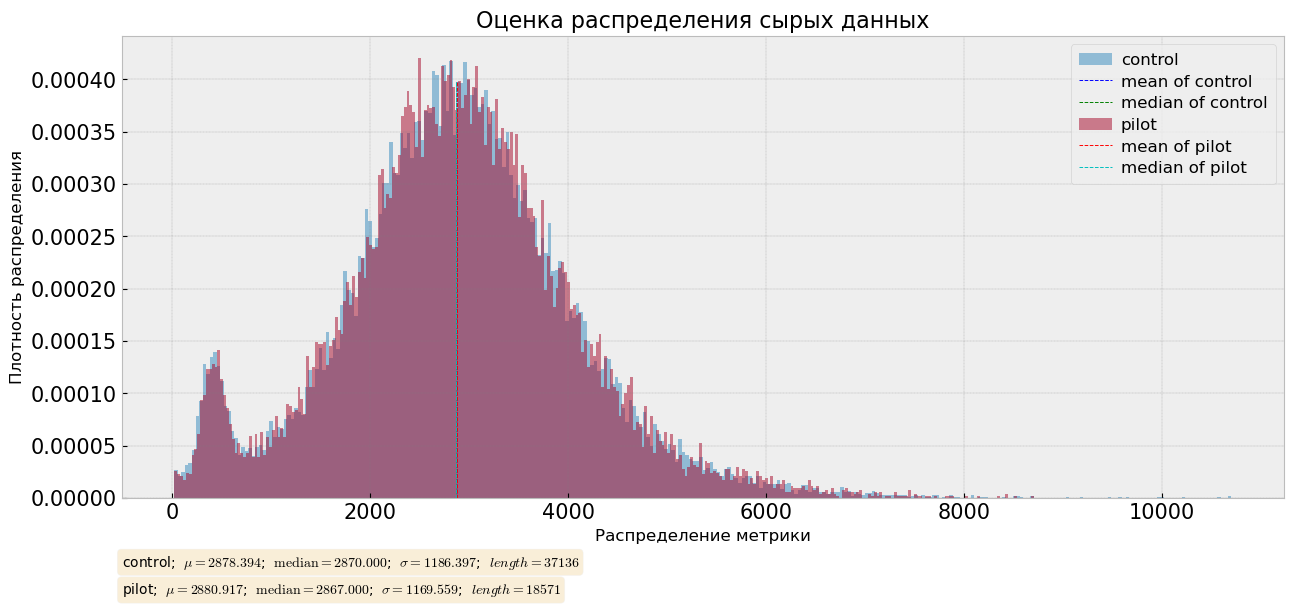

In [47]:
m1 = control_pilot_groups[control_pilot_groups['group']=='A']['sales_sum_target']
m2 = control_pilot_groups[control_pilot_groups['group']=='B']['sales_sum_target']
ab_exp_2.data_distribution_plot([m1, m2], ['control', 'pilot'])

## Оценка результатов

Предполагается, что пользователь собирает и доводит данные экспериментального периода до нужного вида самостоятельно.

In [48]:
design_users = control_pilot_groups['user_id']

In [49]:
experiment_period_ = sales_[sales_['day'].between(8, 14)] # Пусть эксперимент длился с 8 по 14 день
experiment_period_users = experiment_period_[experiment_period_['user_id'].isin(design_users)]

In [50]:
experiment_period_users.head()

,user_id,day,sales
75,1041736,9,576
76,1041736,9,718
77,1041736,10,61
78,1041736,10,332
79,1041736,11,331


In [51]:
# Оставляем только тех пользователей, которые участвуют в эксперименте
# Для тех, кто не выжил в эксперименте, проставляем 0, новых пользователей пока тоже не учитываем
experiment_period_groups = pd.merge(
    control_pilot_groups[['user_id', 'group']],
    experiment_period_users, 
    how='left', 
    on='user_id'
).fillna(0)
experiment_period_groups['period'] = 'pilot'

In [52]:
experiment_period_groups.head()

,user_id,group,day,sales,period
0,5584835,A,9.0,344.0,pilot
1,5584835,A,10.0,236.0,pilot
2,5584835,A,11.0,130.0,pilot
3,5584835,A,12.0,163.0,pilot
4,4927929,A,8.0,378.0,pilot


In [53]:
print(experiment_period_groups[experiment_period_groups['group']=='A']['user_id'].nunique())
print(experiment_period_groups[experiment_period_groups['group']=='B']['user_id'].nunique())

37136
18571


In [54]:
column_for_grouped, exp_ness_cols = ab_exp.get_grouped_columns(experiment_period_groups, ['day'])

In [55]:
exp_ness_cols.head()

,user_id,group,period,sales
0,5584835,A,pilot,344.0
1,5584835,A,pilot,236.0
2,5584835,A,pilot,130.0
3,5584835,A,pilot,163.0
4,4927929,A,pilot,378.0


Рассчитаем метрики для экспериментального периода и коэффициент kappa, если целевая метрика - ratio

In [56]:
exp_agg_df, kappa_dict = ab_exp.calc_metrics(
    exp_ness_cols, 
    column_for_grouped, 
    kappa=None, 
    is_history_data=False)

In [57]:
kappa_dict

{}

In [58]:
exp_agg_df.head()

,user_id,group,period,sales_sum_target,sales_sum_help,sales_ratio_help
0,1000089,A,pilot,0.0,0.0,NaN
1,1000131,A,pilot,516.0,516.0,3.0
2,1000139,B,pilot,2561.0,2561.0,9.0
3,1000304,A,pilot,1584.0,1584.0,5.0
4,1000321,A,pilot,1732.0,1732.0,7.0


Метрики рассчитаны, теперь можем посмотреть на их распределения, провести тест, добавив к пилотной группе эффект того размера, который был в A/A/B тесте.

In [59]:
eff = 28
m1 = exp_agg_df[exp_agg_df['group']=='A']['sales_sum_target']
m2 = exp_agg_df[exp_agg_df['group']=='B']['sales_sum_target'] + eff

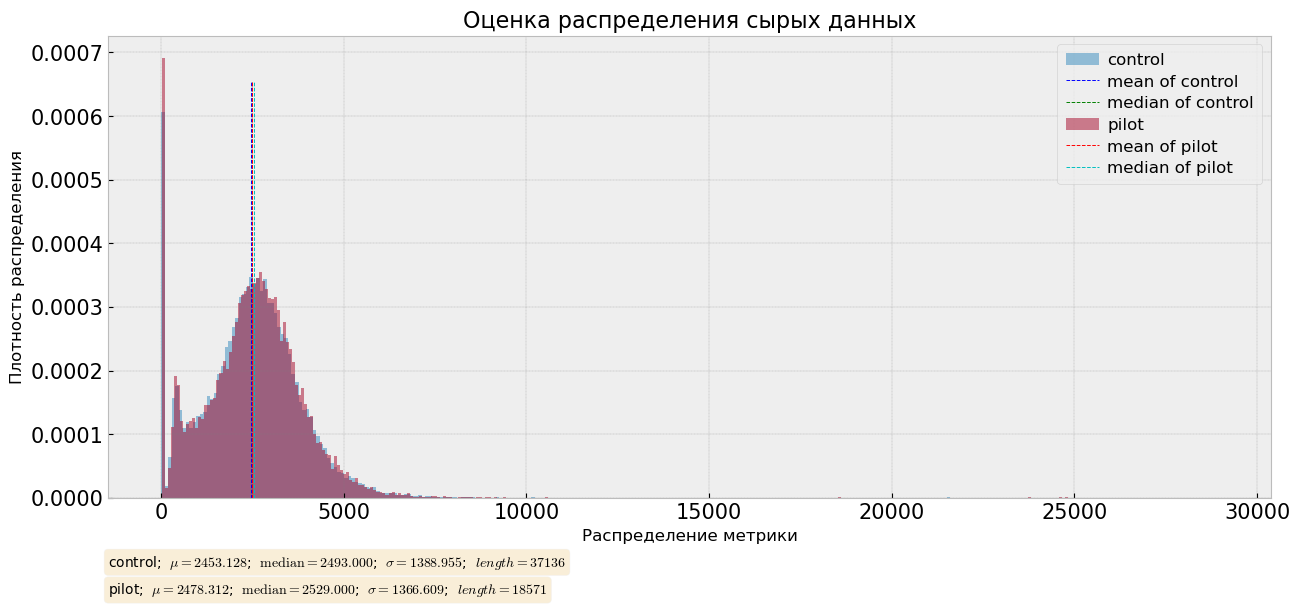

In [60]:
ab_exp.data_distribution_plot([m1, m2], ['control', 'pilot'])

In [61]:
ab_exp.absolute_ttest(m1, m2)

ExperimentComparisonResults(pvalue=0.04142140883850578, effect=25.184649005397205, ci_length=48.41006589240079, left_bound=0.9796160591968075, right_bound=49.389681951597595)

In [62]:
ab_exp.simple_ttest(m1, m2)

0.042538636406509074

Попробуем применить CUPED для снижения дисперсии

In [64]:
cuped = ab_exp.calculate_metric_cuped(control_pilot_groups, exp_agg_df)

2023-11-09 11:49:40.188 | INFO     | t2_ab:calculate_metric_cuped:1165 - Theta is: 0.6730197702472672


In [65]:
cuped.head(2)

,user_id,sales_sum_target,sales_sum_help,sales_ratio_help,gender,age,strat_concat_column,period,group,sales_sum_target_prepilot,sales_sum_target_cuped
0,1000089,484,484,1.0,0,32,0-32,history,A,0.0,484.000000
1,1000131,1891,1891,5.0,0,24,0-24,history,A,516.0,1543.721799


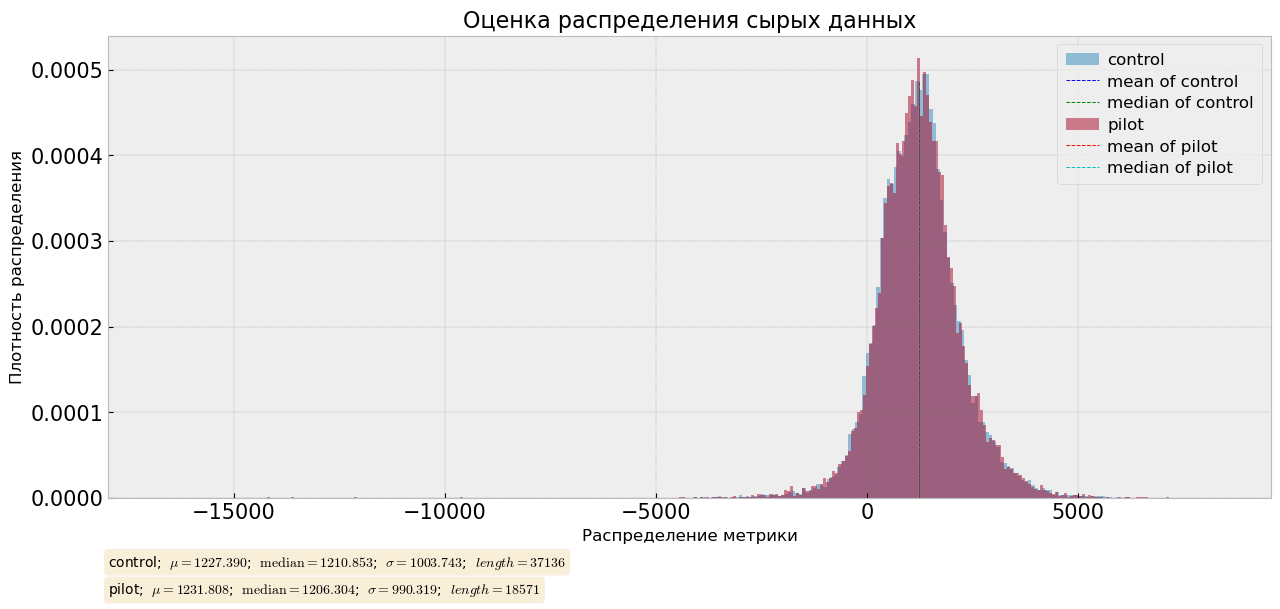

In [72]:
ab_exp.data_distribution_plot(
    [
        cuped[cuped['group']=='A']['sales_sum_target_cuped'],
        cuped[cuped['group']=='B']['sales_sum_target_cuped']
    ],
    ['control', 'pilot']
)

In [74]:
print(f'Получили снижение дисперсии для контрольной группы: {np.round(100 - 1003.743 / 1383.985 * 100, 3)}%')
print(f'Получили снижение дисперсии для пилотной группы: {np.round(100 - 990.319 / 1373.576 * 100, 3)}%')

Получили снижение дисперсии для контрольной группы: 27.474%
Получили снижение дисперсии для пилотной группы: 27.902%


In [70]:
ab_exp.simple_ttest(
    cuped[cuped['group']=='A']['sales_sum_target_cuped'],
    cuped[cuped['group']=='B']['sales_sum_target_cuped'] + eff
)

0.0003070227619361169

In [71]:
ab_exp.absolute_ttest(
    cuped[cuped['group']=='A']['sales_sum_target_cuped'],
    cuped[cuped['group']=='B']['sales_sum_target_cuped'] + eff
)

ExperimentComparisonResults(pvalue=0.00028803937584110707, effect=32.41817385828722, ci_length=35.04771325040187, left_bound=14.89431723308628, right_bound=49.94203048348815)

Если после замены выбросов и снижения дисперсии получаем статистически не значимый результат, то это может быть связано с высокой дисперсией в эксперименте. Необходимо оценить, насколько качественно получилось заменить выбросы на эксперименте: если использовалась оправданная стратегия, например, замена медианой или средним, то принимаем результат с CUPED. Если замена проводилась нулями, то допускается вариант повторной оценки с использованием другой оценки.

In [23]:
spark.stop()